In [3]:
from google.colab import drive
drive.mount('/content/drive/')

#### check for gpu
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    print(local_device_protos)

get_available_gpus()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16521568430678769686
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6034565770428703557
physical_device_desc: "device: XLA_CPU device"
]


In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt

In [5]:
root = '/content/drive/My Drive/SRI/'
trainData = '/content/drive/My Drive/SRI/articles-training-byarticle-20181122.xml'
groundTruth = '/content/drive/My Drive/SRI/ground-truth-training-byarticle-20181122.xml'

In [6]:
#### parse data
import xml.etree.ElementTree as ET

tree = ET.parse(trainData)
root = tree.getroot()

In [7]:
data = pd.DataFrame(columns = ['id', 'text', 'word_count', 'label'])

for child in root:
  text = ET.tostring(child, method='text')
  
  data = data.append({'id': int(child.get('id')), 'text': text } , ignore_index=True)

In [8]:
data.head(5)

,id,text,word_count,label
0,0,b'\nFrom flickr.com: Money {MID-161793} Money ...,NaN,NaN
1,1,b'Donald Trump ran on many braggadocios and la...,NaN,NaN
2,2,b'\nPhoto By Justin Sullivan/Getty Images In r...,NaN,NaN
3,3,b'After Colin Kaepernick rightly chose to knee...,NaN,NaN
4,4,"b'Almost a half-century ago, in 1968, the Unit...",NaN,NaN


In [9]:
!pip install gensim

In [10]:
#### clean data
from gensim.parsing.preprocessing import remove_stopwords, strip_tags, strip_multiple_whitespaces, strip_punctuation2, strip_numeric, stem_text

def clean_data(text):

  tmp = strip_tags(text)
  tmp = strip_multiple_whitespaces(tmp)
  tmp = strip_punctuation2(tmp)
  tmp = strip_numeric(tmp)
  tmp = remove_stopwords(tmp)
  tmp = ' '.join([x.lower() for x in tmp.split(' ')])
  #tmp = stem_text(tmp)

  return tmp


In [11]:
cleanData = data
cleanData['text'] = cleanData['text'].apply(clean_data)

In [12]:
### inspect the cleaned data
cleanData.iloc[0]['text']

'from flickr com money mid money image k permission details dmca no pill can stop tinnitus but this weird trick can the walls closing congress terrifying walls water hurricanes harvey irma damage totaled rise half trillion dollars the walls war the multi trillion dollar ongoing cost afghanistan iraq interventions the crumbling walls u s infrastructure need trillion repaired replaced a wall million undocumented immigrants deportation easily cost billion the planned wall mexican border estimates place billion then wall all trillion national debt the walls debt closing at moments crisis nation addition invoking assistance higher powers constitution guidance article i section u s constitution contains long forgotten provision coinage clause empowered congress coin create money the ability create money meet needs nation sovereign power enables nation control destiny the article indicates founders anticipated having borrow money faith credit united states enter funding act assumed paid debt 

In [13]:
#### get text length distribution
#cleanData.insert(2, 'word_count', cleanData.shape[0]*[0])

In [14]:
print(cleanData)

      id                                               text word_count label
0      0  from flickr com money mid money image k permis...        NaN   NaN
1      1  donald trump ran braggadocios largely unrealis...        NaN   NaN
2      2  photo by justin sullivan getty images in respo...        NaN   NaN
3      3  after colin kaepernick rightly chose kneel nat...        NaN   NaN
4      4  almost half century ago united states falling ...        NaN   NaN
..   ...                                                ...        ...   ...
640  640  donald trump photo whitehouse gov madison u s ...        NaN   NaN
641  641  president donald trump tuesday began dismantli...        NaN   NaN
642  642  the us supreme court ruled donald trump s ban ...        NaN   NaN
643  643  ex fbi director james comey went rogue accordi...        NaN   NaN
644  644  ashley judd absolute worst i want like i somet...        NaN   NaN

[645 rows x 4 columns]


In [15]:
cleanData['word_count'] = cleanData.apply(lambda x: len(x.text.split(' ')), axis=1)

In [16]:
print(cleanData)

      id                                               text  word_count label
0      0  from flickr com money mid money image k permis...         818   NaN
1      1  donald trump ran braggadocios largely unrealis...         121   NaN
2      2  photo by justin sullivan getty images in respo...          94   NaN
3      3  after colin kaepernick rightly chose kneel nat...         176   NaN
4      4  almost half century ago united states falling ...         481   NaN
..   ...                                                ...         ...   ...
640  640  donald trump photo whitehouse gov madison u s ...         148   NaN
641  641  president donald trump tuesday began dismantli...         479   NaN
642  642  the us supreme court ruled donald trump s ban ...         131   NaN
643  643  ex fbi director james comey went rogue accordi...          64   NaN
644  644  ashley judd absolute worst i want like i somet...         219   NaN

[645 rows x 4 columns]


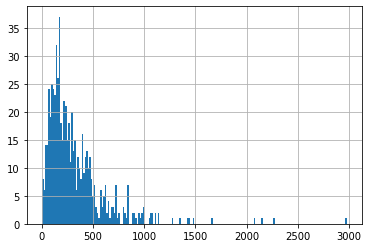

In [17]:
hist = cleanData['word_count'].hist(bins=200)

In [18]:
####### add labels
tree = ET.parse(groundTruth)
root = tree.getroot()


for child in root:
  id = int(child.get('id'))

  label = 1 if child.get('hyperpartisan') == "true" else 0

  cleanData.loc[id, 'label'] = label

print(cleanData)

      id                                               text  word_count label
0      0  from flickr com money mid money image k permis...         818     1
1      1  donald trump ran braggadocios largely unrealis...         121     1
2      2  photo by justin sullivan getty images in respo...          94     1
3      3  after colin kaepernick rightly chose kneel nat...         176     1
4      4  almost half century ago united states falling ...         481     0
..   ...                                                ...         ...   ...
640  640  donald trump photo whitehouse gov madison u s ...         148     1
641  641  president donald trump tuesday began dismantli...         479     0
642  642  the us supreme court ruled donald trump s ban ...         131     0
643  643  ex fbi director james comey went rogue accordi...          64     0
644  644  ashley judd absolute worst i want like i somet...         219     1

[645 rows x 4 columns]


In [19]:
#### convert longer sequences into 512 chunks
#### id  text  word_count label
chunkSize = 512
finalData = pd.DataFrame(columns=cleanData.columns)

counter = 0
for index, row in cleanData.iterrows():

  if row['word_count'] < 512:
    finalData.loc[counter] = row.values
    counter += 1
  else:

    for idx in range(0, row['word_count'], chunkSize):
      nextIdx = min(idx + chunkSize, row['word_count'])
      #print(idx, nextIdx , row['word_count'])
      txt = row['text'].split(' ')[idx:nextIdx]
      newData = {'id' : counter, 
                 'text': ' '.join(txt),
                 'word_count': len(txt), 
                 'label': row['label']}

      finalData.loc[counter] = newData
      counter += 1


print(finalData)

      id                                               text word_count label
0      0  from flickr com money mid money image k permis...        512     1
1      1  irma damage totaled rise half trillion dollars...        306     1
2      1  donald trump ran braggadocios largely unrealis...        121     1
3      2  photo by justin sullivan getty images in respo...         94     1
4      3  after colin kaepernick rightly chose kneel nat...        176     1
..   ...                                                ...        ...   ...
772  640  donald trump photo whitehouse gov madison u s ...        148     1
773  641  president donald trump tuesday began dismantli...        479     0
774  642  the us supreme court ruled donald trump s ban ...        131     0
775  643  ex fbi director james comey went rogue accordi...         64     0
776  644  ashley judd absolute worst i want like i somet...        219     1

[777 rows x 4 columns]


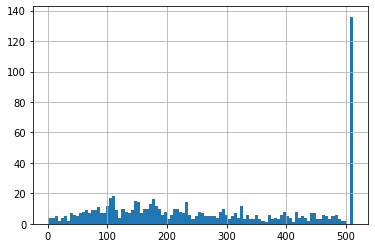

In [20]:
hist = finalData['word_count'].hist(bins=100)

In [21]:
#### helper plot function
def plot_acc_loss(history, model):
  plt.plot(history.history['acc'], label='acc')
  plt.plot(history.history['val_acc'], label='val_acc')
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(loc='upper left')
  plt.show()


  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_los')
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(loc='upper right')
  plt.show()

  res = (model.predict(test_dataset) > 0.5).astype(np.int)
  res = [x for l in res for x in l]

  print(res)

  y_true = []
  for _, label in test_dataset:
      tmp = [ x for l in label.numpy().tolist() for x in l]
      y_true.extend(tmp)

  print(y_true)
  print(classification_report(y_true, res))

In [22]:
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [23]:
######################################## Model 2 - universal sentence encoder
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [24]:
###rewrite the variables - keep labels
embeddings = []
labels =  []

############################ get encoded vectors and labels
for index, row in finalData.iterrows():
  tmp = np.array(embed([row['text']])).tolist()
  embeddings.append(tmp[0])
  labels.append(row['label'])

embeddings = np.array(embeddings)
labels = np.expand_dims(np.array(labels), axis=1)

print(embeddings.shape)
print(labels.shape)
########################## split the data 

x_train, x_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
######################### build datasets 
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

(777, 512)
(777, 1)
(621, 512)
(621, 1)
(156, 512)
(156, 1)


In [25]:
model = tf.keras.Sequential([                  
    tf.keras.layers.Dense(256, input_shape=(512,), activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1

In [26]:
history = model.fit(train_dataset, batch_size=32, epochs=100, validation_data=test_dataset)

Epoch 1/100
20/20 [==============================] - 0s 14ms/step - loss: 0.6922 - acc: 0.5765 - val_loss: 0.6897 - val_acc: 0.6154
Epoch 2/100
20/20 [==============================] - 0s 6ms/step - loss: 0.6889 - acc: 0.5749 - val_loss: 0.6841 - val_acc: 0.6154
Epoch 3/100
20/20 [==============================] - 0s 6ms/step - loss: 0.6818 - acc: 0.5749 - val_loss: 0.6715 - val_acc: 0.6154
Epoch 4/100
20/20 [==============================] - 0s 6ms/step - loss: 0.6643 - acc: 0.5749 - val_loss: 0.6449 - val_acc: 0.6154
Epoch 5/100
20/20 [==============================] - 0s 6ms/step - loss: 0.6321 - acc: 0.5990 - val_loss: 0.6141 - val_acc: 0.6538
Epoch 6/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5925 - acc: 0.6989 - val_loss: 0.5989 - val_acc: 0.6859
Epoch 7/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5439 - acc: 0.7456 - val_loss: 0.5790 - val_acc: 0.6859
Epoch 8/100
20/20 [==============================] - 0s 6ms/step - loss: 0.4987 - 

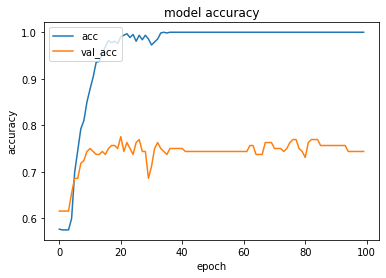

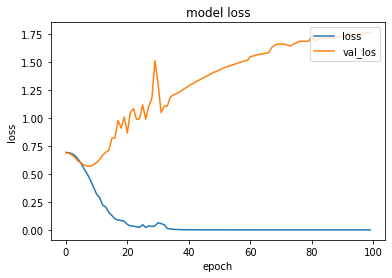

[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0]
              precision    recall  f1-score   support

       

In [27]:
###### model 2 results
plot_acc_loss(history, model)